In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from surrogate_model_training_data import get_data

# Get network informations

In [4]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_dt1h_both_datasets.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_dt1h_both_datasets.json')
n_clusters = 30

# Create Training Data:

## with random control input:

In [6]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
n_arx = 0
nn_input_rc, nn_output_rc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)

Apply filters:

In [14]:
f_1 = (nn_output_rc[('aux_outputs','pump_energy')]<=-10).any(axis=1)
f_2 = (nn_output_rc[('aux_outputs','jun_cl_press_mean')]<=0).any(axis=1)

jun_cl_press_fac_max = pressure_factor.groupby(cluster_labels.loc['pressure_cluster'], axis=1).max()
f_3 = ((nn_output_rc[('aux_outputs','jun_cl_press_mean')]*jun_cl_press_fac_max.to_numpy())>=400).any(axis=1)

In [15]:
nn_input_rc_filtered = nn_input_rc.loc[~f_1 & ~f_2 & ~f_3]
nn_output_rc_filtered = nn_output_rc.loc[~f_1 & ~f_2 & ~f_3]

In [16]:
nn_input_rc_filtered.shape

(17691, 46)

## without random control input:

In [33]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_nc, nn_output_nc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



In [34]:
nn_input = pd.concat((nn_input_rc_filtered, nn_input_nc.head(nn_input_rc_filtered.shape[0]//2)), axis=0)
nn_output = pd.concat((nn_output_rc_filtered, nn_output_nc.head(nn_output_rc_filtered.shape[0]//2)), axis=0)

In [35]:
nn_input.shape

(26536, 46)

## Manually extend data to balance histogramms on input space

In [55]:
cond = nn_input[('sys_states','tank_press','T6')]<5
nn_input = pd.concat((nn_input, nn_input.loc[cond]))
nn_output = pd.concat((nn_output, nn_output.loc[cond]))

In [49]:
nn_input.shape

(31170, 46)

<IPython.core.display.Javascript object>


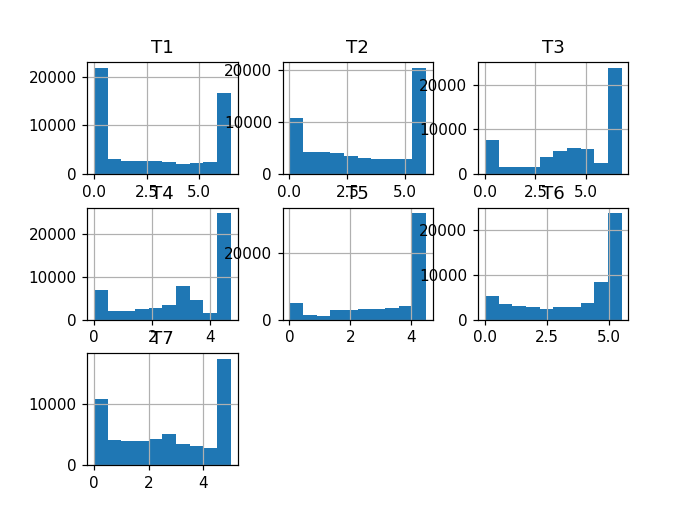

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fca964904d0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fca964bdfd0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fca96482510>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7fca96438d10>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fca963f7550>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fca963abd50>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7fca9636c590>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fca9631fd90>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fca9632b910>]], dtype=object)

In [54]:
nn_input[('sys_states','tank_press')].hist()
#nn_input[('sys_inputs','head_pump_speed')].hist()
#nn_input[('sys_inputs','PRValve_dp')].hist()
#nn_input[('sys_inputs','TCValve_throttle')].hist()
#nn_input[('sys_inputs','jun_cl_demand_sum')].hist()


### Normalize Data:

In [56]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [58]:
X_train.shape

(76836, 46)

# Neural Network

## Create Model

In [59]:
n_layer = 5
n_units = 50
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                2350      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 42)                2142      
Total params: 12,142
Trainable params: 12,142
Non-trainable params: 0
_________________________________________________________

## Train model

In [60]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [62]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=8000, 
                    epochs=3000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 76836 samples, validate on 19210 samples
Epoch 1/3000
76836/76836 [==============================] - 1s 8us/sample - loss: 0.0144 - val_loss: 0.0142
Epoch 2/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0143 - val_loss: 0.0141
Epoch 3/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0142 - val_loss: 0.0140
Epoch 4/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0141 - val_loss: 0.0139
Epoch 5/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0140 - val_loss: 0.0139
Epoch 6/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0139 - val_loss: 0.0138
Epoch 7/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0138 - val_loss: 0.0137
Epoch 8/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0138 - val_loss: 0.0136
Epoch 9/3000
76836/76836 [==============================] - 1s 7us/sample - loss: 0.01

Epoch 76/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0065 - val_loss: 0.0065
Epoch 77/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0065 - val_loss: 0.0064
Epoch 78/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0064 - val_loss: 0.0064
Epoch 79/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0064 - val_loss: 0.0063
Epoch 80/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0063 - val_loss: 0.0063
Epoch 81/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0063 - val_loss: 0.0062
Epoch 82/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0063 - val_loss: 0.0062
Epoch 83/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0062 - val_loss: 0.0062
Epoch 84/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0062 - val_loss: 0.0061
Epoch 85/3000
76836

76836/76836 [==============================] - 1s 8us/sample - loss: 0.0049 - val_loss: 0.0049
Epoch 151/3000
76836/76836 [==============================] - 1s 8us/sample - loss: 0.0050 - val_loss: 0.0049
Epoch 152/3000
76836/76836 [==============================] - 1s 10us/sample - loss: 0.0050 - val_loss: 0.0049
Epoch 153/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0049 - val_loss: 0.0049
Epoch 154/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0050 - val_loss: 0.0051
Epoch 155/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0050 - val_loss: 0.0050
Epoch 156/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0049 - val_loss: 0.0048
Epoch 157/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0049 - val_loss: 0.0048
Epoch 158/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 159/3000
76836/768

76836/76836 [==============================] - 1s 7us/sample - loss: 0.0043 - val_loss: 0.0049
Epoch 225/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0044 - val_loss: 0.0042
Epoch 226/3000
76836/76836 [==============================] - 1s 7us/sample - loss: 0.0042 - val_loss: 0.0041
Epoch 227/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 228/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 229/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 230/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0040 - val_loss: 0.0040
Epoch 231/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0040 - val_loss: 0.0040
Epoch 232/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0040 - val_loss: 0.0040
Epoch 233/3000
76836/7683

76836/76836 [==============================] - 0s 4us/sample - loss: 0.0035 - val_loss: 0.0036
Epoch 299/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0035 - val_loss: 0.0034
Epoch 300/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 301/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0036 - val_loss: 0.0034
Epoch 302/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0036 - val_loss: 0.0038
Epoch 303/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0036 - val_loss: 0.0034
Epoch 304/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0034 - val_loss: 0.0034
Epoch 305/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0034 - val_loss: 0.0034
Epoch 306/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0034 - val_loss: 0.0034
Epoch 307/3000
76836/7683

76836/76836 [==============================] - 1s 7us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 373/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 374/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 375/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 376/3000
76836/76836 [==============================] - 1s 8us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 377/3000
76836/76836 [==============================] - 1s 7us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 378/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 379/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 380/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 381/3000
76836/7683

76836/76836 [==============================] - 0s 5us/sample - loss: 0.0027 - val_loss: 0.0026
Epoch 447/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 448/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 449/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 450/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 451/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 452/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0027 - val_loss: 0.0026
Epoch 453/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 454/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0027 - val_loss: 0.0026
Epoch 455/3000
76836/7683

76836/76836 [==============================] - 0s 5us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 521/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0024 - val_loss: 0.0026
Epoch 522/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0025 - val_loss: 0.0024
Epoch 523/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 524/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 525/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 526/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 527/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0024 - val_loss: 0.0023
Epoch 528/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0024 - val_loss: 0.0023
Epoch 529/3000
76836/7683

76836/76836 [==============================] - 0s 5us/sample - loss: 0.0022 - val_loss: 0.0021
Epoch 595/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0021
Epoch 596/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0021
Epoch 597/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0021
Epoch 598/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0021
Epoch 599/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0022 - val_loss: 0.0021
Epoch 600/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0023 - val_loss: 0.0022
Epoch 601/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0023 - val_loss: 0.0022
Epoch 602/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0023 - val_loss: 0.0022
Epoch 603/3000
76836/7683

76836/76836 [==============================] - 0s 6us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 669/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 670/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0027 - val_loss: 0.0022
Epoch 671/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0022 - val_loss: 0.0022
Epoch 672/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 673/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 674/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 675/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 676/3000
76836/76836 [==============================] - 1s 8us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 677/3000
76836/7683

76836/76836 [==============================] - 0s 5us/sample - loss: 0.0019 - val_loss: 0.0021
Epoch 743/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 744/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0020 - val_loss: 0.0019
Epoch 745/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 746/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0019 - val_loss: 0.0019
Epoch 747/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0019 - val_loss: 0.0019
Epoch 748/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 749/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0020 - val_loss: 0.0018
Epoch 750/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 751/3000
76836/7683

76836/76836 [==============================] - 0s 5us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 817/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 818/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 819/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 820/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 821/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0018 - val_loss: 0.0018
Epoch 822/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0019 - val_loss: 0.0019
Epoch 823/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 824/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 825/3000
76836/7683

76836/76836 [==============================] - 1s 7us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 891/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 892/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0019 - val_loss: 0.0017
Epoch 893/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 894/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 895/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 896/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 897/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 898/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 899/3000
76836/7683

76836/76836 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 965/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 966/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 967/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 968/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 969/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 970/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 971/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 972/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 973/3000
76836/7683

76836/76836 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1039/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1040/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 1041/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1042/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1043/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1044/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1045/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0015
Epoch 1046/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 1047/3000
7

Epoch 1112/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1113/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1114/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1115/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 1116/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1117/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1118/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1119/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1120/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0015
E

76836/76836 [==============================] - 1s 7us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1186/3000
76836/76836 [==============================] - 1s 11us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1187/3000
76836/76836 [==============================] - 1s 10us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1188/3000
76836/76836 [==============================] - 1s 11us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1189/3000
76836/76836 [==============================] - 1s 11us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 1190/3000
76836/76836 [==============================] - 1s 11us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 1191/3000
76836/76836 [==============================] - 1s 9us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1192/3000
76836/76836 [==============================] - 1s 8us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1193/3000
76836/76836 [==============================] - 1s 11us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 1194/

Epoch 1259/3000
76836/76836 [==============================] - 1s 8us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1260/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1261/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1262/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1263/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1264/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 1265/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1266/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1267/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0016 - val_loss: 0.0014
E

Epoch 1333/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1334/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1335/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1336/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1337/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0013
Epoch 1338/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1339/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 1340/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1341/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0013
E

Epoch 1407/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0013
Epoch 1408/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1409/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 1410/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 1411/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1412/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1413/3000
76836/76836 [==============================] - 1s 9us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1414/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1415/3000
76836/76836 [==============================] - 1s 8us/sample - loss: 0.0014 - val_loss: 0.0016
E

Epoch 1481/3000
76836/76836 [==============================] - 1s 7us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1482/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1483/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1484/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1485/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1486/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1487/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 1488/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 1489/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0014 - val_loss: 0.0015
E

Epoch 1555/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1556/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1557/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1558/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0013
Epoch 1559/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1560/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1561/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1562/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 1563/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0013
E

Epoch 1629/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1630/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0012
Epoch 1631/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1632/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1633/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1634/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1635/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1636/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1637/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0012
E

Epoch 1703/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1704/3000
76836/76836 [==============================] - 1s 7us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1705/3000
76836/76836 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1706/3000
76836/76836 [==============================] - 1s 8us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1707/3000
76836/76836 [==============================] - 1s 10us/sample - loss: 0.0014 - val_loss: 0.0013
Epoch 1708/3000
76836/76836 [==============================] - 1s 10us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1709/3000
76836/76836 [==============================] - 1s 8us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1710/3000
76836/76836 [==============================] - 1s 8us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1711/3000
76836/76836 [==============================] - 1s 8us/sample - loss: 0.0012 - val_loss: 0.0012

Epoch 1777/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1778/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1779/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 1780/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1781/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1782/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1783/3000
76836/76836 [==============================] - 0s 4us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 1784/3000
76836/76836 [==============================] - 1s 7us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 1785/3000
76836/76836 [==============================] - 0s 5us/sample - loss: 0.0012 - val_loss: 0.0012
E

Save model:

In [69]:
model_path = './models/'
model_name = '005_man_5x50_both_datasets_filtered'
model.save(model_path+model_name+'.h5')

train_data_param={
    'input_offset': input_offset,
    'input_scaling': input_scaling,
    'output_offset': output_offset,
    'output_scaling': output_scaling
}

with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
    pickle.dump(train_data_param, f)

# Validation

In [64]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/Validation/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

In [65]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [66]:
val_i = 0

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [67]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


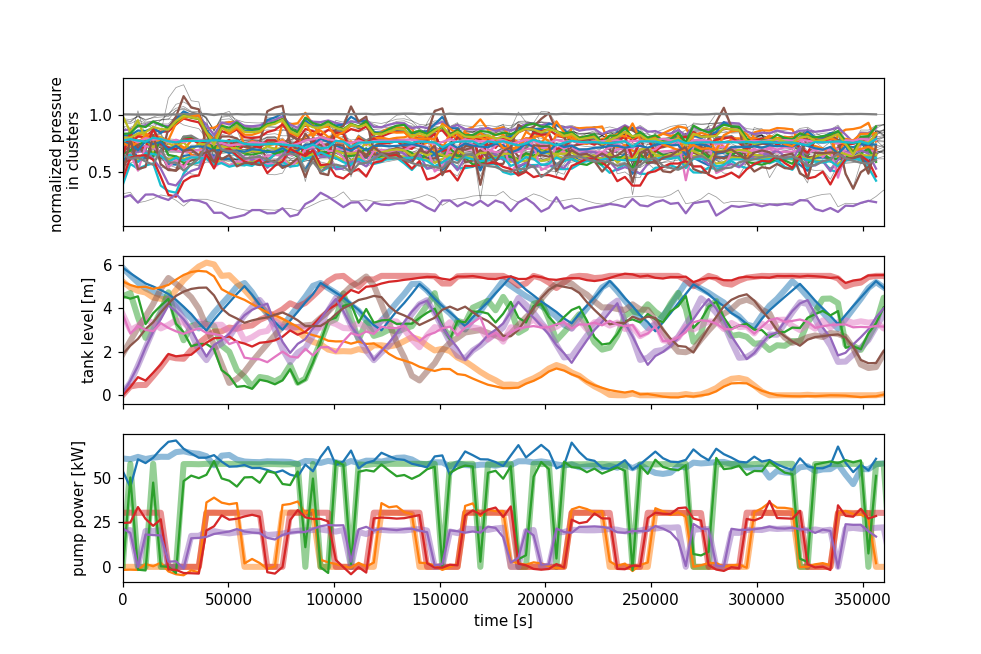

Text(0.5, 0, 'time [s]')

In [68]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [32]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [33]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [34]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


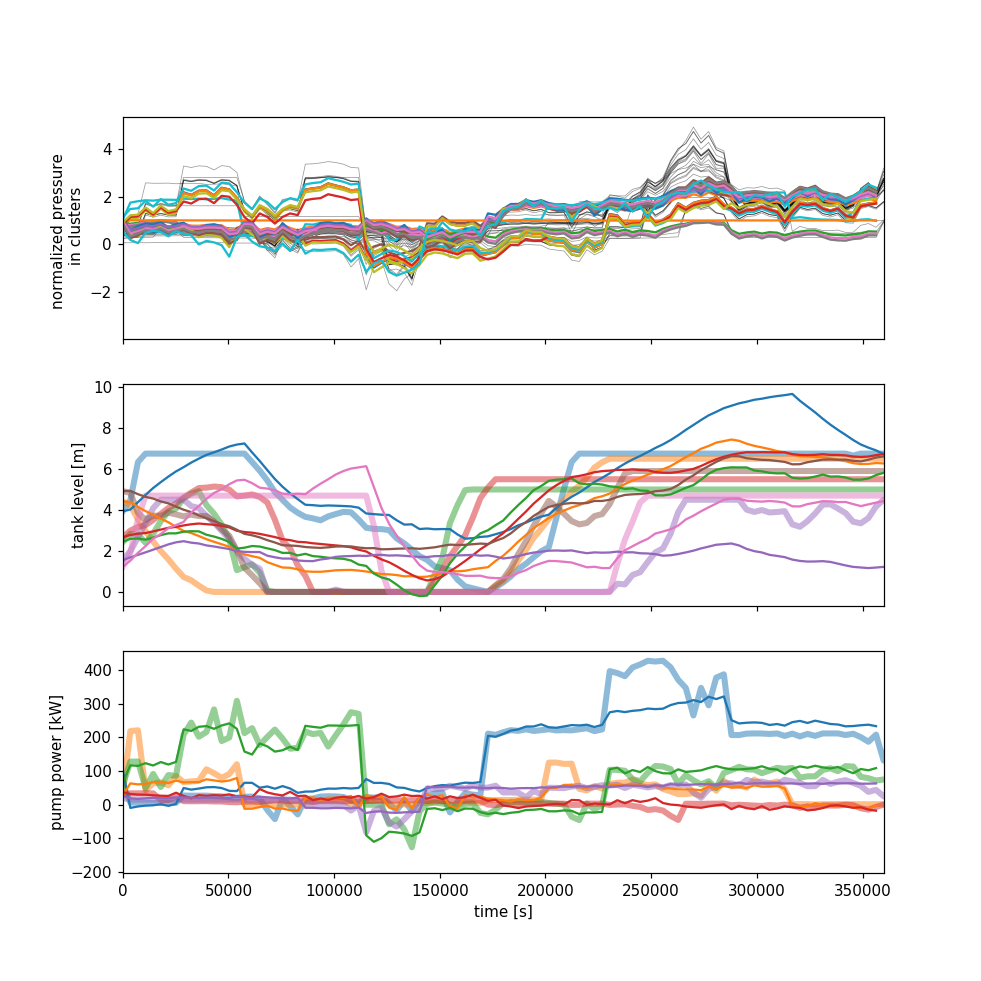

Text(0.5, 0, 'time [s]')

In [35]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')